# Photutils tutorial


## Morphological properties
Source: https://photutils.readthedocs.io/en/stable/morphology.html

## Elliptical Isophote Analysis
Source: https://photutils.readthedocs.io/en/stable/isophote.html

In [1]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_noise_image
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, data_properties
from astropy.io import fits

In [2]:
#data = g(x, y) + noise
hdu=fits.open('/Users/lasilla/data/2020-02-10/reduced/NGC2997/NGC2997_I.fits')
data = hdu['PRIMARY'].data

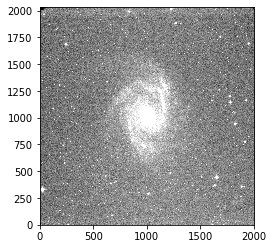

In [3]:
# how does it look?
plt.imshow(data, cmap='gray', origin='lower', vmin=12, vmax=17)

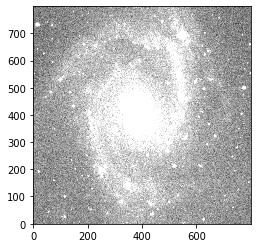

In [4]:
#cut
from astropy.nddata import Cutout2D
position = (1010, 1003)
size=(800,800)
cutout=Cutout2D (data,position,size)
plt.imshow(cutout.data,cmap='gray', origin='lower', vmin=12, vmax=17)

We first need to estimate an initial guess of the ellipse geometry and pass it to the fitters.

In [5]:
# image statistics 
mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
# subract background
data_sub = cutout.data - median
# first guess
cat = data_properties(data_sub)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = cat.to_table(columns=columns)
# initialize an ellipse with the properties that we guessed
geometry = EllipseGeometry(x0=tbl['xcentroid'][0].value,
                           y0=tbl['ycentroid'][0].value,
                           pa=tbl['orientation'][0].value,
                           sma=tbl['semimajor_axis_sigma'][0].value,
                           eps=tbl['semiminor_axis_sigma'][0].value/tbl['semimajor_axis_sigma'][0].value
                           )

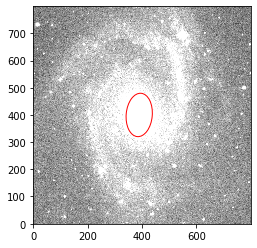

In [13]:
# how does it look?
geometry = EllipseGeometry (x0=390, y0=400, sma=80, eps=0.6,pa=85*np.pi/180)

plt.imshow(cutout.data, cmap='gray', origin='lower', vmin=12, vmax=17)
geometry.sma
aper = EllipticalAperture(positions=(geometry.x0, geometry.y0), 
                          a=geometry.sma,
                          b=geometry.sma*(geometry.eps),
                          theta=geometry.pa)
aper.plot(color='r')

Now we want to initiliaze an instance of the Ellipse class with the data and our initial guess and fit the data:

In [14]:
ellipse = Ellipse(data_sub, geometry)
isolist = ellipse.fit_image()

In [15]:
# save the output as a table
tab = isolist.to_table()
tab

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_err,grad_rerr,x0,x0_err,y0,y0_err,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,int64,int64,int64,int64
0.0,154.43335055115296,0.0,0.0,0.0,0.0,0.0,0.0,None,None,388.9171016458651,0.0,408.9057311926452,0.0,1,0,0,0
0.5120090926822315,149.33935456075173,0.15580111952495382,0.09212039310498368,0.02236594015869321,29.287315203132103,7.7859662784776,-13.309973489991606,4.5603944009355475,0.34262986356544756,388.9171016458651,0.006266826994954965,408.9057311926452,0.006152759872736764,13,0,10,0
0.5632100019504547,148.67334814945323,0.14531967943972282,0.0963911198998111,0.018920011837860486,32.711442724791006,6.308611041506847,-13.283038326477898,3.8893053288751642,0.2928023870203229,388.9072774489647,0.0058405953812829285,408.89282704147985,0.005744668120371796,13,0,10,0
0.6195310021455002,147.98007345824675,0.1487030045849138,0.1012742881863877,0.0176239279446113,35.003781421484256,5.606840904713072,-13.19602300574875,3.6216183855997817,0.27444771686303143,388.89509670755274,0.005993747016102737,408.87890636517864,0.005898660344142818,13,0,10,0
0.6814841023600502,147.251204071701,0.1587795291963432,0.10875042867556053,0.017133147603287435,36.34717749444154,5.0967516800009465,-13.062836666036826,3.5169247154370833,0.2692313167002259,388.8819286976192,0.0064453421504422626,408.8637978026633,0.006343487383093142,13,0,10,0
0.7496325125960552,146.4784903758741,0.1723219362372071,0.11810992966929416,0.016933500151747896,37.57090774577877,4.663920933826597,-12.900622242785703,3.4682361471784953,0.2688425474296796,388.86723282737387,0.007050963277109972,408.84648513699136,0.006936839692461741,13,0,10,0
0.8245957638556608,145.64958792051812,0.1867759073043736,0.1277390772821233,0.016425685566520402,38.233150208463044,4.20339833487029,-12.963483703579579,3.35510380354921,0.25881189657551484,388.8500615011968,0.00756954131383447,408.8270889982975,0.007438279118422503,13,0,10,0
0.9070553402412269,144.69851184782445,0.20743322751896434,0.13459848015585665,0.014054652842814411,40.38248806004871,3.4238704031950435,-15.183449696632705,3.3099431689072594,0.2179967816958829,388.8345912673404,0.007146676157070778,408.80707985815053,0.0070488374208632345,13,0,10,0


Text(0, 0.5, 'Ellipticity')

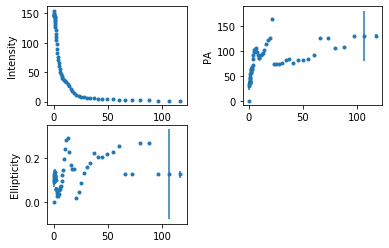

In [16]:
# have a look at some of the fitted parameters:
fig = plt.figure()
ax1 = fig.add_subplot(221)
fig.subplots_adjust(wspace=0.4)
ax1.errorbar(tab['sma'], tab['intens'],
             yerr=tab['intens_err'],
             fmt='.')
ax1.set_ylabel('Intensity')
ax2 = fig.add_subplot(222, sharex=ax1)
ax2.errorbar(tab['sma'], tab['pa'].value,
             yerr=tab['pa_err'].value,
             fmt='.')
ax2.set_ylabel('PA')
ax3 = fig.add_subplot(223, sharex=ax1)
ax3.errorbar(tab['sma'], tab['ellipticity'],
             yerr=tab['ellipticity_err'],
             fmt='.')
ax3.set_ylabel('Ellipticity')
# ax4 = fig.add_subplot(224, sharex=ax1)
# ax4.errorbar(tab['sma'], tab['x0'],
#              yerr=tab['x0_err'],
#              fmt='.')
# ax4.set_ylabel('x0')

We can also build a model image from the fit that we just calculated and deterime the residuals of the fit:

In [17]:
model_image = build_ellipse_model(cutout.data.shape, isolist)
residual = cutout.data - model_image

Text(0.5, 1.0, 'Residual')

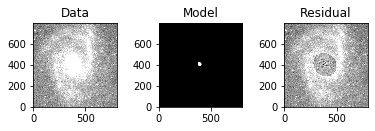

In [18]:
fig = plt.figure()
fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(131)
ax1.imshow(cutout.data, cmap='gray', origin='lower', vmin=12, vmax=17)
ax1.set_title('Data')
ax2 = fig.add_subplot(132)
ax2.imshow(model_image, cmap='gray', origin='lower', vmin=12, vmax=17)
ax2.set_title('Model')
ax3 = fig.add_subplot(133)
ax3.imshow(residual, cmap='gray', origin='lower', vmin=12, vmax=17)
ax3.set_title('Residual')